# CZĘŚĆ 1:

## Wstęp

Choroby sercowo-naczyniowe są główną przyczyną zgonów na całym świecie. Niewydolność serca jest częstym zdarzeniem spowodowanym przez właśnie takie choroby. Aby zapobiec niewydolnościom serca, osoby z chorobami sercowo-naczyniowymi lub z wysokim ryzykiem sercowo-naczyniowym wymagają odpowiednio wcześniejszego diagnozowania.

Celem projektu jest opracowanie modelu uczenia maszynowego, potrafiącego z wysokim prawdopodobieństwem trafnie określić, czy u danej osoby może występować choroba serca, lub zwiększone ryzyko wykształcenia choroby serca.

Optymalizując modele maksymalizowana będzie dokładności i czułości modelu jednocześnie. Ze względu na medyczną tematykę badania, fałszywy pozytyw niesie za sobą dużo niższe konsekwencje niż fałszywy negatyw, dlatego czułość będzie dla nas ważniejszą miarą od specyficzności.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Opis zmiennych
- Age: wiek pacjenta w latach
- Sex: płeć pacjenta - M: Mężczyzna, F: Kobieta
- ChestPainType: rodzaj bólu w klatce piersiowej - TA: typowa dławica piersiowa, ATA: atypowa dławica piersiowa, NAP: ból niedławicowy, ASY: bezobjawowy
- RestingBP: (RestingBloodPressure) spoczynkowe ciśnienie krwi w mm Hg
- Cholesterol: cholesterol w surowicy w mm/dl
- PostingBS: (PostingBloodSugar) poziom cukru we krwi na czczo - 1: jeśli PostingBS > 120 mg/dl, 0: w przeciwnym wypadku
- RestingECG: EKG spoczynkowe, spoczynkowe wyniki elektrokardiogramu - Normal: prawidłowe, ST: nieprawidłowości załamka ST-T (odwrócenie załamka T i/lub uniesienie lub obniżenie ST > 0,05 mV), LVH: prawdopodobny lub wyraźny przerost lewej komory według kryteriów Estesa
- MaxHR: osiągnięte maksymalne tętno - wartość liczbowa od 60 do 202 uderzeń na minutę
- ExerciseAngina: wystąpienie dławicy wywołanej wysiłkiem fizycznym - Y: Tak, N: Nie
- Oldpeak: depresja odczytu sektora ST przez elektrokardiograf w wartości liczbowej
- ST_Slope: nachylenie szczytowego odcinka ST - Up: w górę, Flat: płasko, Down: w dół
- HeartDisease: występowanie choroby serca - 1: choroba serca, 0: brak choroby serca

# 0. Ogólny zarys danych, ocena kompletności

In [2]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


## Typy danych

In [3]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

## Zbalansowanie zbioru danych:
Zestaw danych jest zbalansowany pod kątem zmiennej objaśnianej

In [4]:
df.HeartDisease.value_counts(normalize=True)

HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64

## Duplikaty, wartości brakujące

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

W zbiorze danych nie wystąpiły żadne duplikaty ani wartości brakujące

# 1. Oczyszczanie danych

## Unikatowe wartości w kolumnach

In [7]:
for col in df:
  unique_values = df[col].unique()
  print(f"{col}:\n{np.sort(unique_values)}\n")

Age:
[28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77]

Sex:
['F' 'M']

ChestPainType:
['ASY' 'ATA' 'NAP' 'TA']

RestingBP:
[  0  80  92  94  95  96  98 100 101 102 104 105 106 108 110 112 113 114
 115 116 117 118 120 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 148 150 152 154 155 156
 158 160 164 165 170 172 174 178 180 185 190 192 200]

Cholesterol:
[  0  85 100 110 113 117 123 126 129 131 132 139 141 142 147 149 152 153
 156 157 159 160 161 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 190 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 26

Spoczynkowe ciśnienie krwi oraz stężenie cholesterolu przyjmują dla niektórych obserwacji wartości 0, co jest niemożliwe (chyba że pacjent jest martwy). Oldpeak, czyli depresja odczytu sektora ST przez elektrokardiograf przyjmuje wartości ujemne, co nie powinno mieć miejsca. Usuniemy te wartości.

In [10]:
df = df[(df['RestingBP'] > 0) & (df['Cholesterol'] > 0) & (df['Oldpeak'] >= 0)]
df.shape

(745, 12)

In [11]:
df.HeartDisease.value_counts(normalize=True)

HeartDisease
0    0.522148
1    0.477852
Name: proportion, dtype: float64

# 2. EDA

## Podstawowe statystyki danych numerycznych:

In [12]:
num_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[num_columns].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,745.000000,745.000000,745.000000,745.000000,745.000000
mean,52.906040,133.036242,244.747651,140.209396,0.902953
std,9.489625,17.290451,59.113689,24.536108,1.072953
min,28.000000,92.000000,85.000000,69.000000,0.000000
25%,46.000000,120.000000,208.000000,122.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000
75%,59.000000,140.000000,275.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


Znacznie wyższa wartość średniej od mediany zmiennej Oldpeak sugeruje występowanie asymetrii prawostronnej rozkładu wartości tej zmiennej. Dla pozostałych zmiennych wartości średnich są zbliżone do wartości median, co wskazuje na rozkłady o braku lub niskiej asymetrii.

Wartości Oldpeak najbardziej odchylają się przeciętnie od swojej średniej. Odchylenie standardowe dla zmiennych Cholesterol i MaxHR jest też relatywnie duże.

Wartości maksymalne zmiennych Cholesterol i Oldpeak są kilkukrotnie większe od średniej, co wskazuje na występowanie wartości odstających.

## Struktura i rozkłady zmiennych numerycznych

### Wykresy pudełkowe

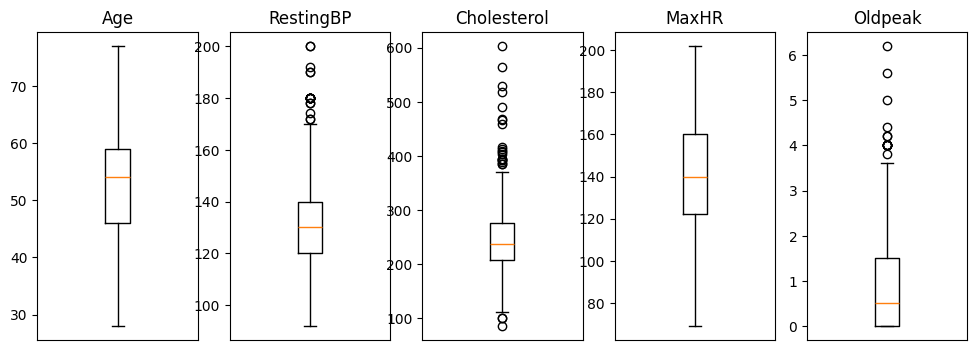

In [13]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,5)
axs = gs.subplots()

for i, col in enumerate(num_columns):
    axs[i].boxplot(df[col])
    axs[i].set_title(col)
    
for ax in axs:
    ax.set_xticks([]) 

Kolumny Cholesterol, Oldpeak i RestingBP zawierają wysokie wartości odstające. Teoretycznie, wysokie wartości tych parametrów mogą przyczynić się do wystąpienia choroby serca.

Rozkład Oldpeak jest silnie prawostronnie asymetryczny. Mniej intenswyną asymetrię wykazały natomiast Cholesterol i RestingBP.

### Correlation matrix

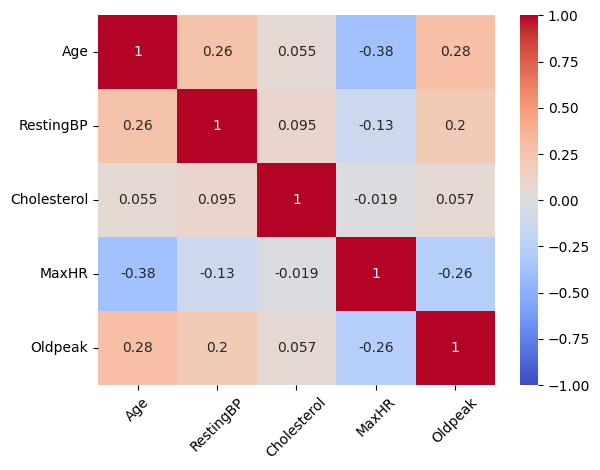

In [14]:
sns.heatmap(df[num_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Zmiennymi Age i Oldpeak są pozytywnie skorelowane. Intensywność korelacji jest niska. Jako że większe wartości Oldpeak świadczą o niższej wydolności serca, jest to logicznie spójne zjawisko, ponieważ wydolność serca ma tendencję obniżania się z wiekiem.
Zmienna Age jest też negatywnie skorelowana z MaxHR, co znowu świadczy o malejącej wydolności serca wraz z wiekiem. Osoby starsze mają też tendencję do wyższych poziomów spoczynkowego ciśnienia krwi. 
Odczyty maksymalnego tętna wśród badanych osób są odwrotnie skorelowane z depresją sektora ST (zmienna Oldpeak).

Nie stwierdzono występowania silnej korelacji pomiędzy żadnymi ze zmiennych. Oznacza to, że współliniowość wśród ilościowych zmiennych objaśniających nie występuje.

### Rozłożenie osób z chorobą serca i bez wśród zmiennych numerycznych

In [15]:
pairplot_num_columns = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']

<Figure size 1000x1000 with 0 Axes>

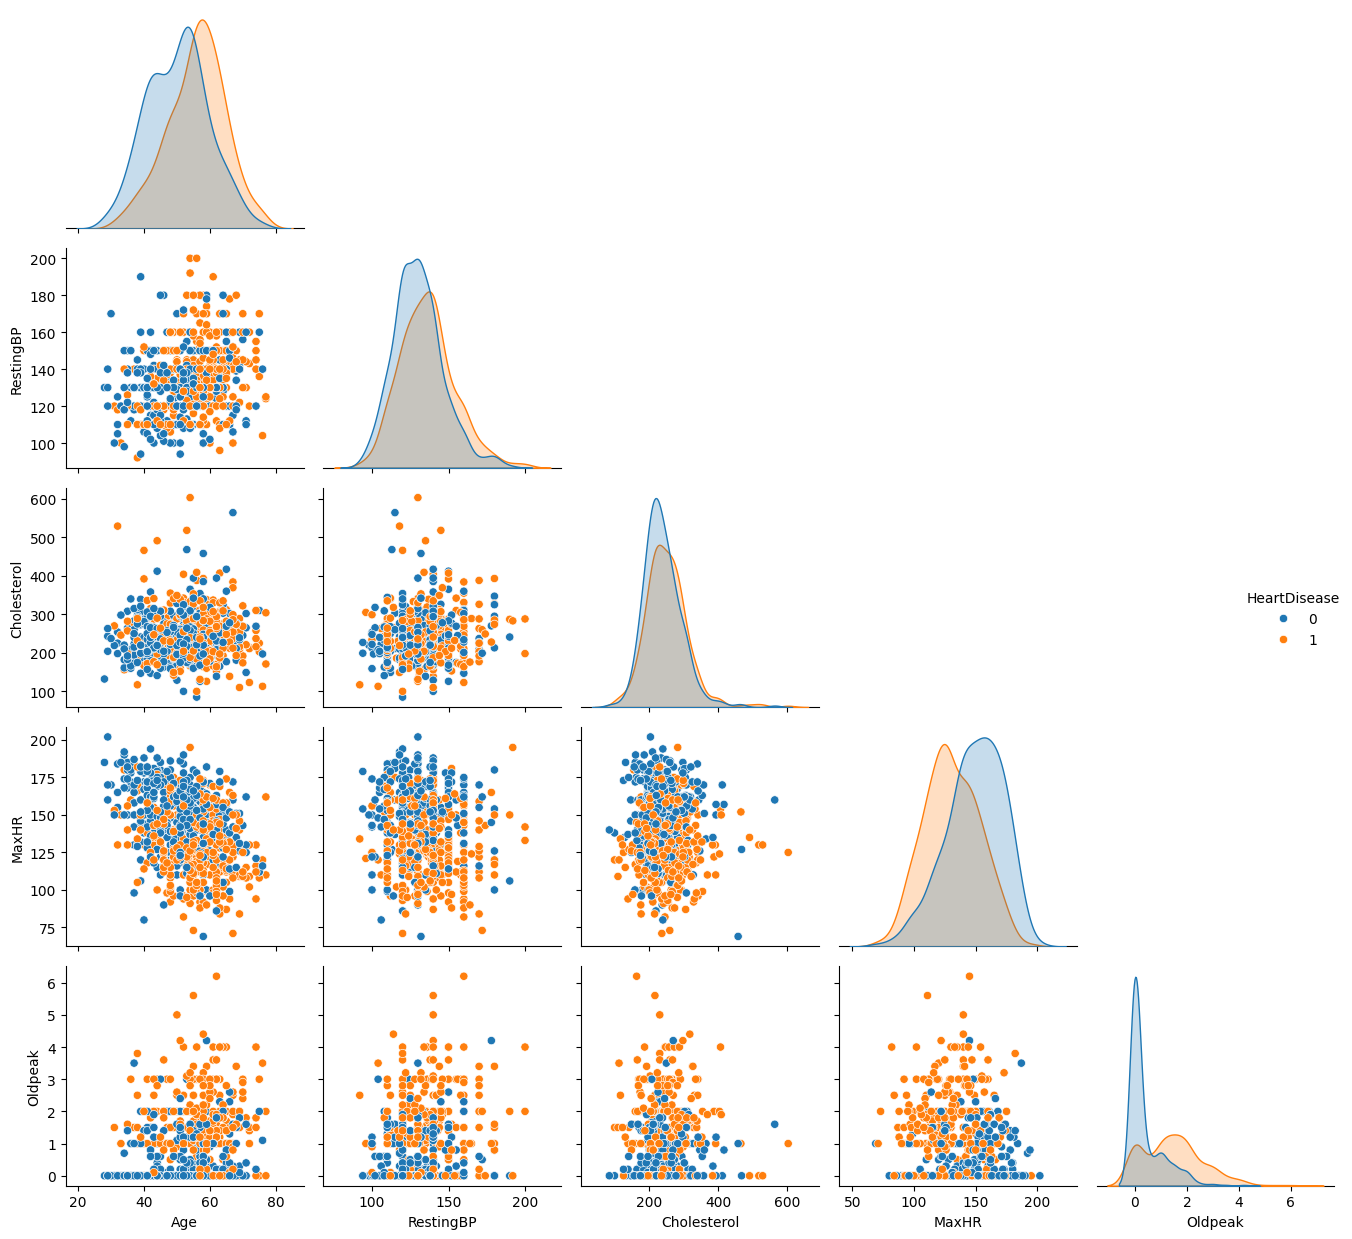

In [16]:
plt.figure(figsize=(10,10))
sns.pairplot(df[pairplot_num_columns], hue='HeartDisease', corner=True)
plt.tight_layout()
plt.show()

Wykres częstości osób z chorobą serca przyjmuje największe wartości dla wyższych wartości wieku niż wykres częstości osób bez choroby serca. Wskazuje to na pozytywny wpływ wieku na pradwopodobieństwo wystąpienia choroby serca.

Struktura osób chorych na serce i zdrowych pod kątem wysokości spoczynkowego ciśnienia krwi jest podobna. Wykres częstości dla osób zdrowych jest nieco przesunięty w lewo w stosunku do wykresu częstości dla osób chorych, co wskazuje na większe szanse klasyfikacji jako osoba zdrowa, kiedy nasze spoczynkowe ciśnienie krwi jest niższe. 

Wykresy częstości dla osób chorych i zdrowych pod kątem poziomu cholesterolu są bardzo zbliżone. Pojawiają się przypadki osób zdrowych z bardzo wysokimi poziomami chlesterolu, jednak osób chorych z wyoskim poziomem cholesterolu jest więcej niż zdrowych.

Wyższe wartości maksymalnego odczytanego tętna negatywnie powinny wpływać na prawdopodobieństwo wystąpienia choroby serca. Chorzy na serce osiągali przeciętnie niższe wartości maksymalnego tętna niż pacjenci zdrowi.

Depresja odczytu sektora ST przez elektrokardiograf (Oldpeak) jest zerowa dla zdecydowanej większości pacjentów zdrowych. Zerowa wartość oznacza porpawne funkcjonowanie serca. U osób chorych, wartość Oldpeak najczęściej wynosi od ok. 1 do 2.25. Największe wartości Oldpeak osiągali jedynie pacjenci chorzy.

## Zmienne kategoryczne

In [17]:
original_categorical_columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

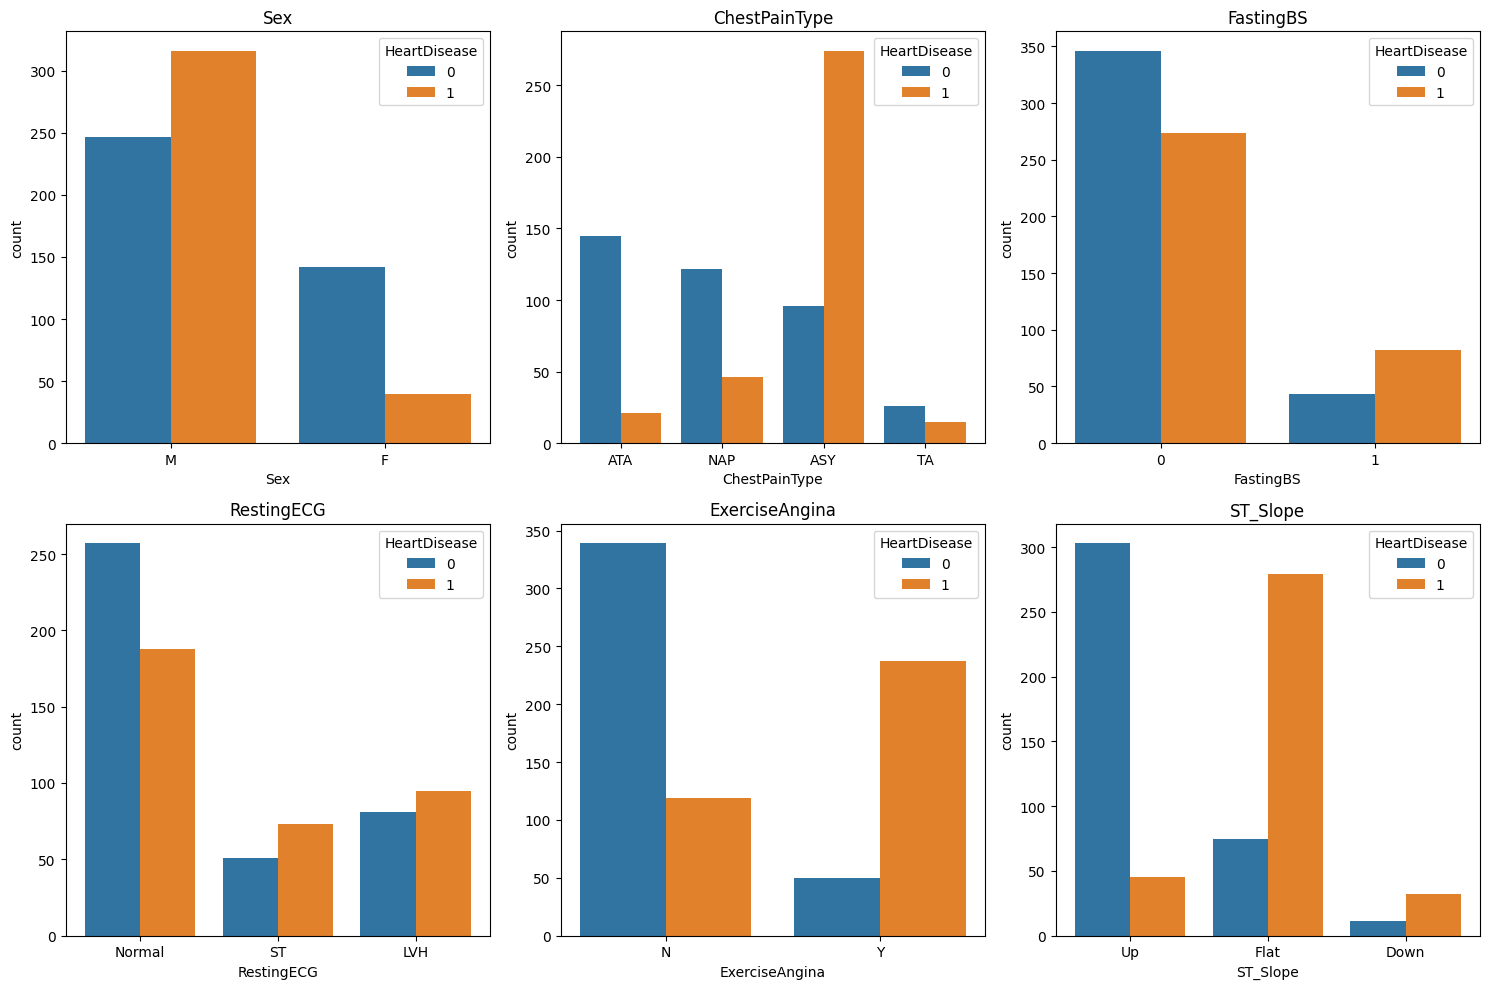

In [18]:
plt.figure(figsize=(15,10))

for i,col in enumerate(df[original_categorical_columns],1):
    plt.subplot(2,3,i)
    sns.countplot(df, x=col, hue="HeartDisease")#, legend=False)
    plt.title(col)
    plt.tight_layout()
    plt.plot()

Wśród badanych pacjentów, osoby chore były głównie płci męskiej. Nie duża część badanych kobiet miała chorobę serca.

Pacjenci, u których nie występował ból w klatce piersiowej byli w dużej większości pacjentami chorymi. Osoby odczuwające jakiś rodzaj bólu w klatce piersiowej najczęściej są osobami bez choroby serca.

Osoby, których poziom cukru we krwi na czczo przekraczał 120 mg/dl były w większości diagnozowane jako chore. Mimo wszystko dużo osób chorych wykazywało normalne poziomy cukru we krwi na czczo.

Osoby z normalnymi spoczynkowe wyniki elektrokardiogramu były głównie osobami zdrowymi, chociaż dla dużej ilości osób chorych wyniki te też nie odchodziły od normy. Nieprawidłowości załamka ST-T oraz przerost lewej komory według kryteriów Estesa były diagnozowane częściej u pacjentów z chorobą serca.

Wystąpienie dławicy po wysiłku fizycznym jest miarą wysoce wyróżniającą osoby chore.

Nachylenie szczytowego odcinka ST inne niż w górę może z wysokim prawdopodobieństwem oznaczać występowanie choroby serca.

# 3. OHE - Transformacja danych

In [19]:
dummy_columns = df.select_dtypes(include="object").columns
df_dummies = pd.get_dummies(df, columns=dummy_columns)


categorical_columns = ['Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_ASY', 'ChestPainType_TA',
                       'RestingECG_Normal','RestingECG_LVH', 'RestingECG_ST', 'FastingBS', 'ExerciseAngina_Y',
                       'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

df_dummies.drop(['Sex_F', 'ExerciseAngina_N'], axis=1, inplace=True)


for column in df_dummies.columns:
    if column in categorical_columns:
        df_dummies[column] = df_dummies[column].astype(int)

df = df_dummies

In [20]:
df

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,1,0,0,0,1,0,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,0,1,0,0,1,0,0,0,1,0
2,37,130,283,0,98,0.0,0,1,0,1,0,0,0,0,1,0,0,0,1
3,48,138,214,0,108,1.5,1,0,1,0,0,0,0,1,0,1,0,1,0
4,54,150,195,0,122,0.0,0,1,0,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,110,264,0,132,1.2,1,1,0,0,0,1,0,1,0,0,0,1,0
914,68,144,193,1,141,3.4,1,1,1,0,0,0,0,1,0,0,0,1,0
915,57,130,131,0,115,1.2,1,1,1,0,0,0,0,1,0,1,0,1,0
916,57,130,236,0,174,0.0,1,0,0,1,0,0,1,0,0,0,0,1,0


# 4. X, y, train test split; Zbalansowanie zestawów danych po podziale

In [21]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True, stratify=y)

## Zmienna objaśniana

In [23]:
print(y_train.value_counts(normalize=True)*100, y_test.value_counts(normalize=True)*100)

HeartDisease
0    52.181208
1    47.818792
Name: proportion, dtype: float64 HeartDisease
0    52.348993
1    47.651007
Name: proportion, dtype: float64


## Statystyki zmiennych objaśniających

In [24]:
X_train.describe(include='all')

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,53.169463,133.338926,245.828859,0.161074,140.256711,0.903523,0.753356,0.506711,0.211409,0.226510,0.055369,0.238255,0.604027,0.157718,0.387584,0.057047,0.484899,0.458054
std,9.356783,17.472645,59.828024,0.367908,24.460901,1.060539,0.431420,0.500375,0.408651,0.418924,0.228891,0.426374,0.489470,0.364783,0.487608,0.232127,0.500192,0.498656
min,29.000000,92.000000,85.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,46.000000,120.000000,210.000000,0.000000,122.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,238.500000,0.000000,140.000000,0.550000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,140.000000,275.250000,0.000000,160.000000,1.500000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,77.000000,200.000000,603.000000,1.000000,195.000000,5.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
X_test.describe(include='all')

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,51.852349,131.825503,240.422819,0.194631,140.020134,0.900671,0.765101,0.456376,0.268456,0.221477,0.053691,0.228188,0.570470,0.201342,0.375839,0.060403,0.436242,0.503356
std,9.966414,16.543036,56.150880,0.397252,24.917016,1.124932,0.425366,0.499773,0.444651,0.416641,0.226168,0.421080,0.496679,0.402356,0.485972,0.239035,0.497591,0.501675
min,28.000000,94.000000,132.000000,0.000000,73.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,120.000000,199.000000,0.000000,122.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,130.000000,230.000000,0.000000,140.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,59.000000,140.000000,275.000000,0.000000,158.000000,1.600000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,77.000000,180.000000,404.000000,1.000000,202.000000,6.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Rozkłady zmiennych numerycznych

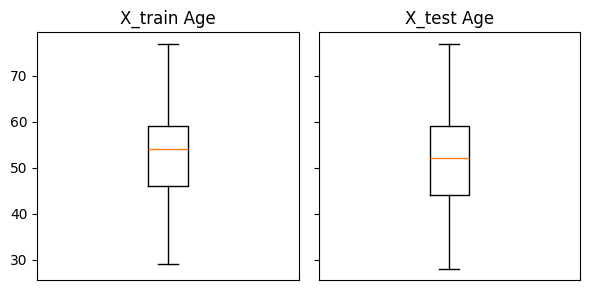

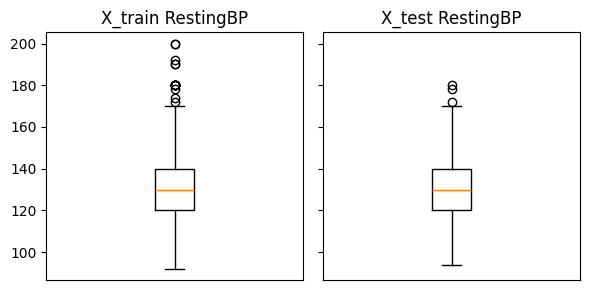

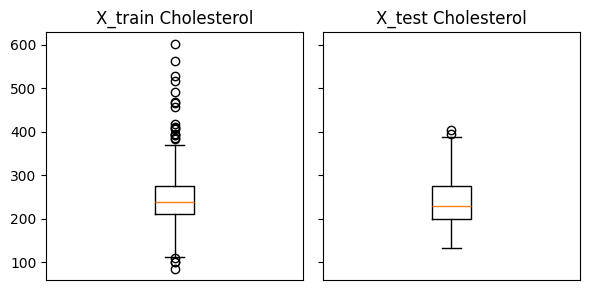

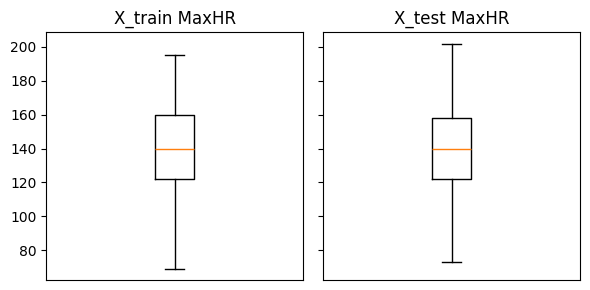

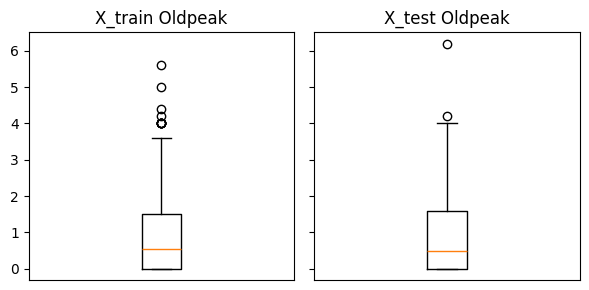

In [26]:
for col in num_columns:
    fig = plt.figure(figsize=(6,3))
    gs = fig.add_gridspec(1,2)
    axs = gs.subplots(sharey=True)
    
    axs[0].boxplot(X_train[col])
    axs[0].set_title(f"X_train {col}")
    
    axs[1].boxplot(X_test[col])
    axs[1].set_title(f"X_test {col}")
        
    for ax in axs:
        ax.set_xticks([])
    
    plt.tight_layout()

Struktury danych zmiennych objaśniającyh ilościowych są do siebie zbliżone dla danych trenujących i testowych. Większość outlierów wylądowała w zbiorze uczącym, co może mieć potencjalnie pozytywny wpływ na nasz model, zaznajamiając go z całym dostępnym zakresem wartości zmiennych.

## Rozkłady zmiennych kategorycznych

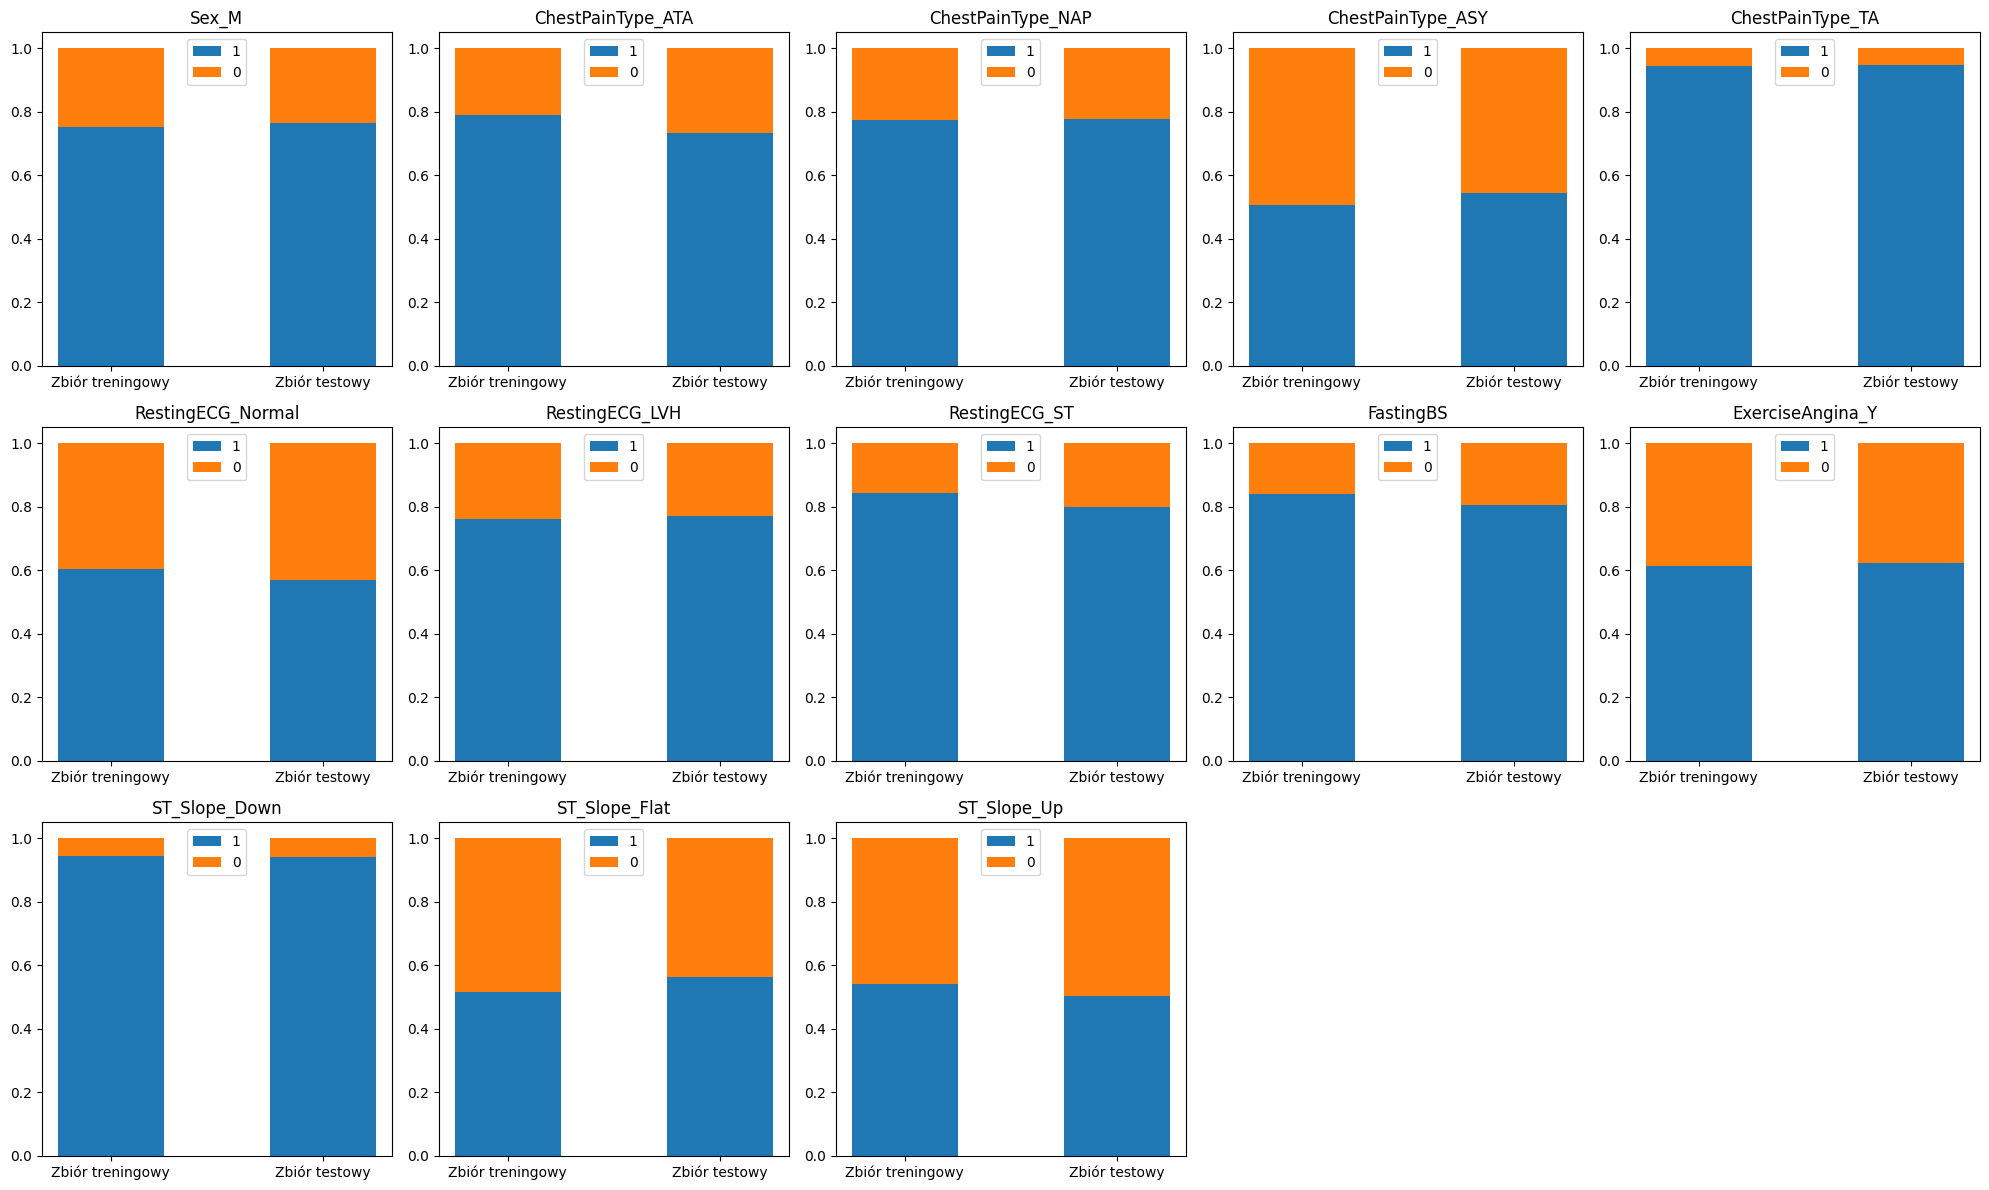

In [27]:
nrows = 3
ncols = 5


fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axs = axs.flatten()

for idx, col in enumerate(categorical_columns):
    VC_X_train = X_train[col].value_counts(normalize=True).tolist()
    VC_X_test = X_test[col].value_counts(normalize=True).tolist()

    nazwy = ("Zbiór treningowy", "Zbiór testowy",)
    
    weight_counts = {"1": np.array([VC_X_train[0], VC_X_test[0]]), 
                     "0": np.array([VC_X_train[1], VC_X_test[1]])}
    width = 0.5
    
    ax = axs[idx]
    bottom = np.zeros(2)
    
    for boolean, weight_count in weight_counts.items():
        p = ax.bar(nazwy, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count
    
    ax.set_title(f"{col}")
    ax.legend(loc="upper center")

for j in range(idx + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Tak jak dla zmienncyh ilościowych, struktury danych zmiennych objaśniającyh kategorycznych są do siebie wielce zbliżone dla danych trenujących i testowych. Proporcje zostały zachowane. Różnice w udziale nigdy nie przekraczają 5 pkt %.

# CZĘŚĆ 2:
- analiza uzyskanych wyników (analiza jakości klasyfikacji, porównanie wyników uzyskanych za pomocą różnych metod)
- analiza interpretowalności (w oparciu o profile ceteric-paribus/wykresy częściowej zależności/wartości SHAP)
- podsumowanie i wnioski

# 1. RANDOM FOREST

## Basic model

Dokładność:     0.846
Czułość:        0.817
Specyficzność:  0.872
Avg Dokładność CV:     0.891
Avg Czułość CV:        0.874


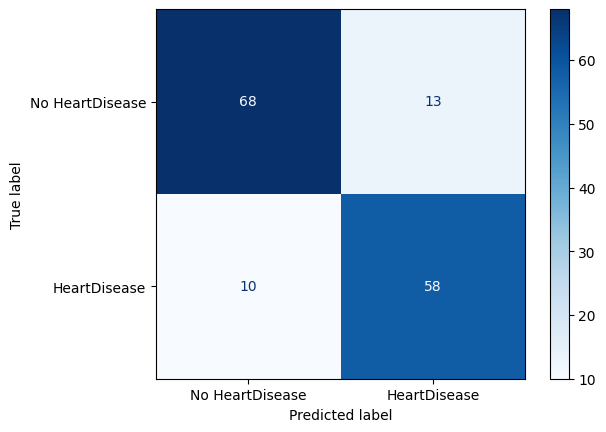

In [28]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")
print(f"Avg Dokładność CV:     {cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean():.3f}")
print(f"Avg Czułość CV:        {cross_val_score(model, X_train, y_train, cv=10).mean():.3f}")

### Sprawdzanie przeuczenia

Dokładność:     1.000
Czułość:        1.000
Specyficzność:  1.000



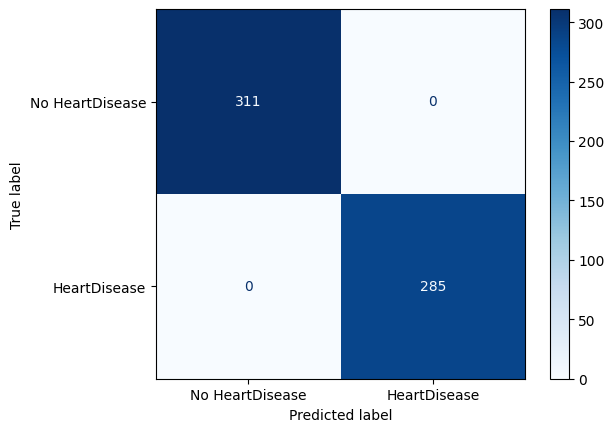

In [29]:
y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_pred, y_train, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_train, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_train, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_train, y_pred, pos_label=0):.3f}")
print()

Domyślny model jest przeuczony i charakteryzuje się niską czułością.

Nasz las losowy klasyfikuje wszystkie obserwacje w treningowym zbiorze danych poprawnie, co może świadczyć o przetrenowaniu i negatywnie wpłynąć na wyniki finalnego modelu na nowych danych. Spróbujemy zmienić parametry, aby polepszyć jakość klasyfikacji naszego modelu.

Drzewa decyzyjne i lasy losowe oferują wiele możliwości dostosowywania hiperparametrów w celu uniknięcia przetrenowania, m.in. głębokość drzewa, liczba obserwacji w węźle. Zmniejszanie skomplikowania drzew decyzyjnych do pewnego momentu może pozytywnie wpłynąć na wyniki modelu. 

Dobrym rozwiązaniem jest użycie Cost complexity pruning. Jest to metoda przycinania drzew decyzyjnych polegająca na redukowaniu drzewa do poziomu, który w największym stopniu redukuje minimalny koszt złożoności. Koszt złożoności to suma 2 składowych: kosztu błędu (prawdopodobieństwa popełnienia błędu klasyfikacji) oraz kosztu złożoności drzewa (liczby węzłów w drzewie).

Metoda iteracyjnie przycina drzewa. Na każdym kroku iteracji określany jest minimalny koszt złożoności dla danego poziomu drzewa. Następnie przycinane jest najniższe rozgałęzienie drzewa, które nie zwiększa minimalnego kosztu złożoności. Za dostosowanie przycięcia, odpowiadać będzie parametr cpp_alpha.

 
Oprócz ograniczenia głębokości drzewa dostosowane będą także parametry takie jak ilość drzew w naszym lesie losowym, funkcja pomiaru jakości podziału.

## Optymalizacja

In [30]:
criterion_list = ['gini', "entropy"]

for criterion in criterion_list:
    model = RandomForestClassifier(random_state=42, n_jobs=-1, criterion=criterion)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{criterion} acc: {accuracy_score(y_test, y_pred):.3f}, rec: {recall_score(y_test, y_pred):.3f}")

gini acc: 0.846, rec: 0.817
entropy acc: 0.839, rec: 0.817


Dla bazowego modelu funkcja Gini pomiaru jakości podziału okazała się być najlepsza.


In [31]:
max_features_list = ['sqrt', 'log2']
for criterion in criterion_list:
    for feature in max_features_list:
        model = RandomForestClassifier(random_state=42, n_jobs=-1, max_features=feature, criterion=criterion)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"{criterion} {feature} acc: {accuracy_score(y_test, y_pred):.3f}, rec: {recall_score(y_test, y_pred):.3f}")

gini sqrt acc: 0.846, rec: 0.817
gini log2 acc: 0.846, rec: 0.817
entropy sqrt acc: 0.839, rec: 0.817
entropy log2 acc: 0.839, rec: 0.817


Zmiana maksymalnej ilości zminnych branych pod uwagę podczas szukania najlepszego rozdzielenia nie wpływa na dokładność naszego modelu.

### Funkcje do rysowania wyników optymalizacji RF

In [48]:
def rf_plot_cpp(criterion, n_trees=100, alphas = np.linspace(0, 0.03, num=75)):
    train_accuracies = []
    test_accuracies = []
    train_recalls = []
    test_recalls = []
    
    for alpha in alphas:
        model = RandomForestClassifier(n_estimators=n_trees, random_state=42, n_jobs=-1, ccp_alpha=alpha, criterion=criterion)
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        train_accuracies.append(accuracy_score(y_train, y_train_pred))
        train_recalls.append(recall_score(y_train, y_train_pred))

        y_test_pred = model.predict(X_test)
        test_accuracies.append(accuracy_score(y_test, y_test_pred))
        test_recalls.append(recall_score(y_test, y_test_pred))
    
    max_acc_idx = np.argmax(test_accuracies)
    max_rec_idx = np.argmax(test_recalls)
    
    max_acc_alpha = alphas[max_acc_idx]
    max_rec_alpha = alphas[max_rec_idx]
    
    max_acc = test_accuracies[max_acc_idx]
    max_rec = test_recalls[max_rec_idx]
    
    print(f'Highest Test Accuracy: {max_acc:.4f} at alpha = {max_acc_alpha:.4f}')
    print(f'Highest Test Recall: {max_rec:.4f} at alpha = {max_rec_alpha:.4f}')
    
    plt.plot(alphas, train_accuracies, 'r--', label='Train Accuracy')
    plt.plot(alphas, test_accuracies, 'r-', label='Test Accuracy')
    plt.plot(alphas, train_recalls, 'g--', label='Train Recall')
    plt.plot(alphas, test_recalls, 'g-', label='Test Recall')
    
    plt.plot(max_acc_alpha, max_acc, 'ro')
    plt.plot(max_rec_alpha, max_rec, 'go')
    
    plt.title(criterion)
    plt.xlabel("Alpha")
    plt.legend()

    plt.show()


In [57]:
def rf_plot_ntrees(criterion, ccp_alpha=0):
    tree_number = 150
    forest_size_list = []
    
    tree_model_acc_test_list = []
    tree_rec_test_list = []
    tree_model_acc_train_list = []
    tree_rec_train_list = []
    
    for tree in range(3, tree_number + 1, 2):
        model = RandomForestClassifier(n_estimators=tree, random_state=42, n_jobs=-1, criterion=criterion, ccp_alpha=ccp_alpha)
        model.fit(X_train, y_train)
        
        y_test_pred = model.predict(X_test)
        tree_model_acc_test_list.append(accuracy_score(y_test, y_test_pred))
        tree_rec_test_list.append(recall_score(y_test, y_test_pred))
        
        y_train_pred = model.predict(X_train)
        tree_model_acc_train_list.append(accuracy_score(y_train, y_train_pred))
        tree_rec_train_list.append(recall_score(y_train, y_train_pred))
    
        forest_size_list.append(tree)
    
    max_acc = np.max(tree_model_acc_test_list)
    max_rec = np.max(tree_rec_test_list)

    optimal_trees_acc = [forest_size_list[i] for i in range(len(forest_size_list)) if tree_model_acc_test_list[i] == max_acc]
    optimal_trees_rec = [forest_size_list[i] for i in range(len(forest_size_list)) if tree_rec_test_list[i] == max_rec]

    print(f"Optimal number of trees for maximum Accuracy: {optimal_trees_acc} with value: {max_acc:.4f}")
    print(f"Optimal number of trees for maximum Recall: {optimal_trees_rec} with value: {max_rec:.4f}")

    plt.plot(forest_size_list, tree_rec_test_list, 'g-', label='Test Recall')
    plt.plot(forest_size_list, tree_model_acc_test_list, 'r-', label='Test Accuracy')
    plt.plot(forest_size_list, tree_rec_train_list, 'g--', label='Train Recall')
    plt.plot(forest_size_list, tree_model_acc_train_list, 'r--', label='Train Accuracy')
    
    plt.title(criterion)
    plt.xlabel('n_trees')
    plt.legend()
    plt.show()

Highest Test Accuracy: 0.8591 at alpha = 0.0061
Highest Test Recall: 0.8451 at alpha = 0.0073


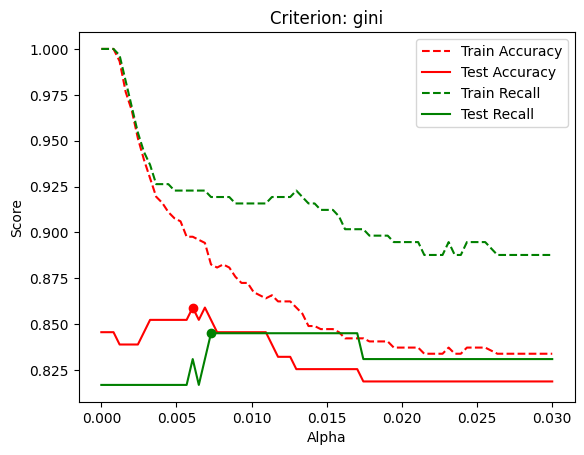

Highest Test Accuracy: 0.8523 at alpha = 0.0089
Highest Test Recall: 0.8451 at alpha = 0.0146


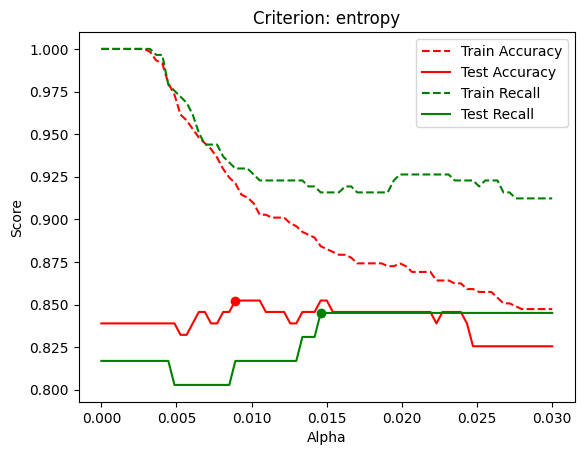

In [46]:
for criterion in criterion_list:
    rf_plot_cpp(criterion)

Aby otrzymać najelepszy model zarówno pod kątem maksymalizacji acc i rec, możemy wybrać zarówno model Entropy z podanymi optymalnymi parametrami.

In [63]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, ccp_alpha=0.015, criterion='entropy')#, n_estimators=45)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Avg Dokładność CV:     {cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean():.3f}")
print(f"Avg Czułość CV:        {cross_val_score(model, X_train, y_train, cv=10).mean():.3f}")

Avg Dokładność CV:     0.908
Avg Czułość CV:        0.867


Dokładność:     0.852
Czułość:        0.845
Specyficzność:  0.859


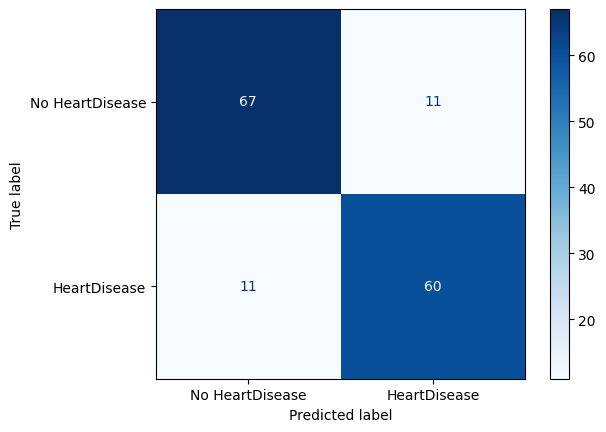

In [64]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")

Delikatnie porprawiając dokładność, zbalansowaliśmy czułość i specyficzność w porównaniu do modelu bazowego.

Dokładność:     0.883
Czułość:        0.916
Specyficzność:  0.852



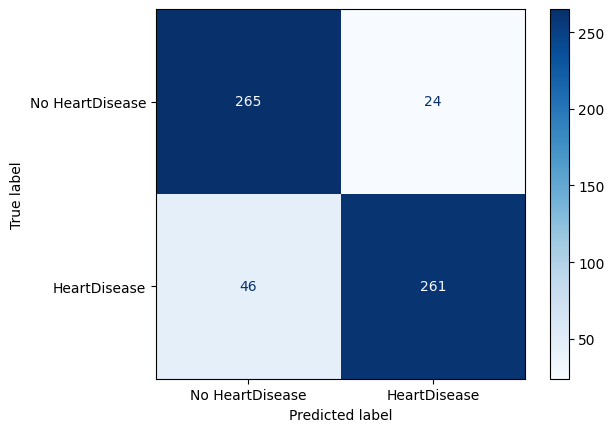

In [65]:
y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_pred, y_train, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_train, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_train, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_train, y_pred, pos_label=0):.3f}")
print()

Parametry dla danych testowych i treningowych zbliżyły się do siebie. Las nie jest już tak przetrenowany. Jednocześnie na zbiorze treningowym czułość zdecydowanie przewyższyła specyficzność

Sprawdzimy teraz wpływ ilości drzew na jakość naszego modelu

Optimal number of trees for maximum Accuracy: [39, 41, 43, 45, 65, 75, 77, 79, 85, 87, 89, 91, 93, 95, 97, 99, 103, 133] with value: 0.8523
Optimal number of trees for maximum Recall: [7, 9, 11] with value: 0.8592


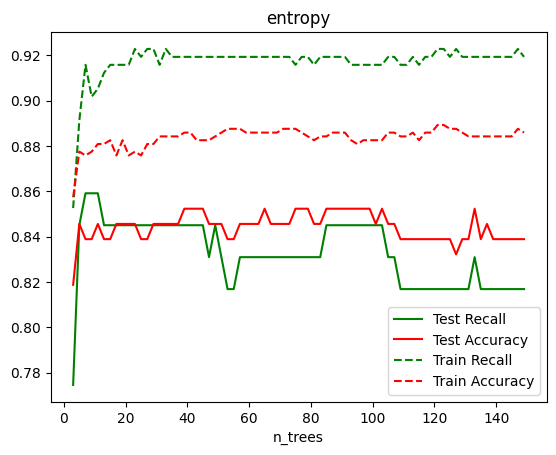

In [58]:
rf_plot_ntrees('entropy', ccp_alpha=0.015)

Obniżając ilość drzew możemy zwiększyć czułość kosztem dokładności. Zobaczymy, czy najpierw optymalizując ilość drzew a astępnie alfę uda nam się uzyskać lepsze wyniki.

Optimal number of trees for maximum Accuracy: [41] with value: 0.8591
Optimal number of trees for maximum Recall: [41, 75, 77, 79, 81, 113, 115, 127, 129, 131, 133, 135] with value: 0.8310


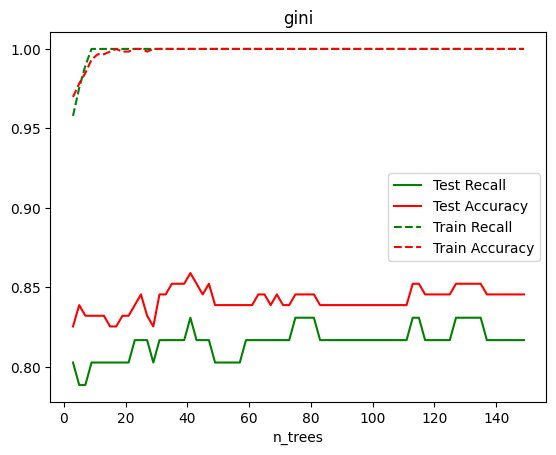

Optimal number of trees for maximum Accuracy: [3, 9, 15, 35, 37, 39, 41, 77, 79, 81] with value: 0.8456
Optimal number of trees for maximum Recall: [3] with value: 0.8310


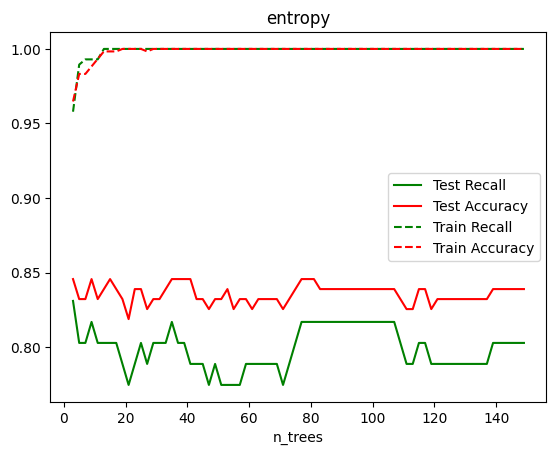

In [59]:
for criterion in criterion_list:
    rf_plot_ntrees(criterion)

Dla domyślnego modelu gini znaleźliśmy lokalne maksium dla 41 drzew, dające najwyższą czułość i dokładność. Przed zastosowaniem ccp model jest ewidentnie przetrenowany.

Highest Test Accuracy: 0.8658 at alpha = 0.0048
Highest Test Recall: 0.8451 at alpha = 0.0071


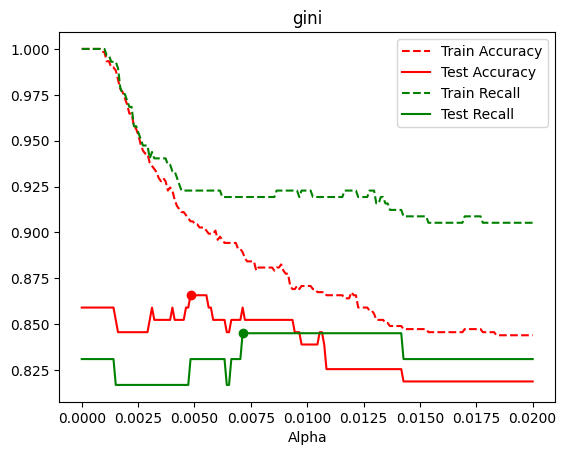

In [51]:
rf_plot_cpp('gini', n_trees=41, alphas = np.linspace(0, 0.02, num=200))

Dokładność:     0.859
Czułość:        0.845
Specyficzność:  0.872
Avg Dokładność CV:     0.901
Avg Czułość CV:        0.864


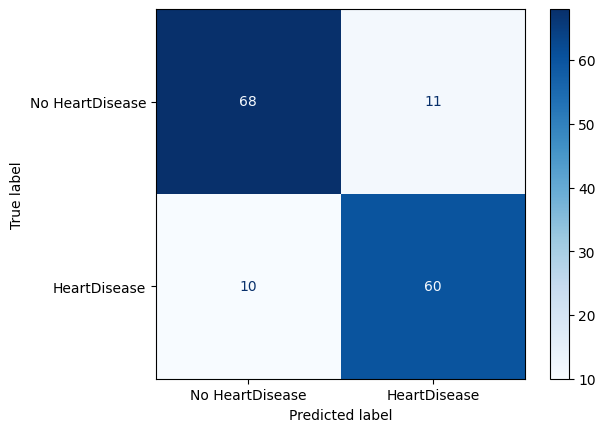

In [53]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, ccp_alpha=0.0071, n_estimators=41)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")
print(f"Avg Dokładność CV:     {cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean():.3f}")
print(f"Avg Czułość CV:        {cross_val_score(model, X_train, y_train, cv=10).mean():.3f}")

Uzyskaliśmy model o tej samej czułości i ciut większej dokładności od popzredniego modelu. Poprzedni model natomiast osiągnął odrobinę wyższe wyniki walidacji krzyżowej.

Dokładność:     0.891
Czułość:        0.919
Specyficzność:  0.865


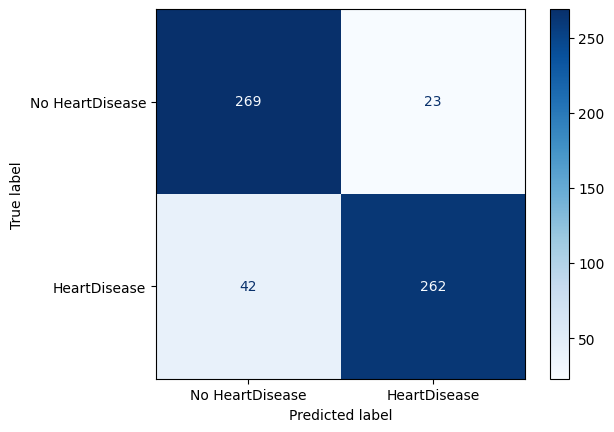

In [54]:
y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_pred, y_train, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_train, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_train, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_train, y_pred, pos_label=0):.3f}")

# Pre 2. Przygotowanie danych przed użyciem modeli odległościowych
Standaryzacja cech ciągłych

In [70]:
scaler = StandardScaler().set_output(transform="pandas")

In [71]:
trans_X_train = scaler.fit_transform(X_train[num_columns])
not_num_X_train = X_train.drop(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], axis=1)
X_train = pd.concat([trans_X_train, not_num_X_train], axis=1)

In [72]:
trans_X_test = scaler.transform(X_test[num_columns])
not_num_X_test = X_test.drop(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak'], axis=1)
X_test = pd.concat([trans_X_test, not_num_X_test], axis=1)

In [73]:
X_test

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
31,0.302766,-0.191255,-1.318698,-1.074317,-0.852663,0,1,0,0,1,0,0,1,0,0,0,0,1
141,-0.339019,0.381549,1.592081,-0.624242,1.506608,0,1,1,0,0,0,0,0,1,1,0,1,0
210,-0.552947,-1.565984,0.287249,-1.237981,-0.852663,1,1,1,0,0,0,0,1,0,0,0,1,0
281,-0.445983,0.954353,-0.398624,-0.746990,1.034754,0,1,1,0,0,0,0,1,0,0,0,1,0
271,-2.264373,-1.623265,-0.800111,1.012394,-0.852663,0,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,1.907228,-1.336863,0.320707,-0.419663,-0.852663,1,0,0,0,1,0,1,0,0,0,0,0,1
447,2.549012,-0.534937,-1.251783,-1.237981,1.034754,0,1,1,0,0,0,0,0,1,1,0,0,1
478,0.409730,-0.191255,1.090223,0.316824,1.034754,1,1,1,0,0,0,0,0,1,1,0,1,0
83,-0.125091,1.527157,-0.833568,1.012394,-0.852663,0,1,0,1,0,0,0,1,0,0,0,0,1


In [74]:
X_train

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,FastingBS,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
767,0.088838,-1.451424,0.354164,1.094226,-0.852663,0,0,0,0,1,0,1,0,0,0,0,0,1
601,0.837586,0.381549,0.638550,-0.706074,0.374158,0,1,0,0,1,0,0,1,0,1,0,1,0
17,-1.087768,-0.764059,-0.749925,1.012394,-0.852663,0,0,0,1,0,0,0,1,0,0,0,0,1
523,0.623658,-0.534937,-1.435798,-0.951569,0.091046,0,1,1,0,0,0,0,1,0,1,0,1,0
606,0.944551,1.527157,0.136692,-1.319813,1.978463,1,1,1,0,0,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,-1.301696,-1.336863,0.069777,0.071328,-0.852663,0,0,0,1,0,0,0,0,1,0,0,0,1
495,1.158479,0.496110,0.504721,-0.010504,0.091046,0,0,1,0,0,0,0,1,0,1,0,1,0
292,-0.018126,-0.191255,-1.067768,0.316824,-0.852663,0,1,1,0,0,0,0,1,0,0,0,0,1
627,-0.980803,0.381549,-0.181152,1.626133,-0.852663,0,1,0,0,1,0,1,0,0,0,0,0,1


# 2. SVM

## Wybór kernela

In [75]:
def svc_kernel(kernel):
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"                {kernel}")
    print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
    print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
    print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")
    print()

In [76]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernel_list:
    svc_kernel(kernel)

                linear
Dokładność:     0.852
Czułość:        0.831
Specyficzność:  0.872

                poly
Dokładność:     0.852
Czułość:        0.803
Specyficzność:  0.897

                rbf
Dokładność:     0.859
Czułość:        0.831
Specyficzność:  0.885

                sigmoid
Dokładność:     0.826
Czułość:        0.789
Specyficzność:  0.859



Niezależnie od jądra, modele radzą sobie bardzo podobnie. Jądro rbf radzi sobie odrobinę lepiej niż jądra liniowe i poly, natomiast jądro sigmoid radzi sobie gorzej. Linear i rbf wykazały się też co ważne najwyższą czułością.

In [77]:
for kernel in kernel_list:
    print(f"{kernel} acc = {cross_val_score(SVC(kernel=kernel, random_state=42), X_train, y_train, cv=10).mean():.3f}, czułość = {cross_val_score(SVC(kernel=kernel, random_state=42), X_train, y_train, cv=10, scoring='recall').mean():.3f} ")

linear acc = 0.856, czułość = 0.870 
poly acc = 0.859, czułość = 0.835 
rbf acc = 0.864, czułość = 0.880 
sigmoid acc = 0.790, czułość = 0.789 


Model rbf uzyskał też najlepszą średnią dokładności i czułości wśród 10 badanych splitów dokonanych za pomocą CV. Będziemy używać modelu z tym jądrem.

Optymalizując nasz model skupimy się na 2 parametrach: C i gamma.

Parametr C będzie odpowiadał za dopuszczalne źle zakwalifikowane obserwajce przez model, kiedy wybiera on najlepszą linię podziału. Zmniejszając C pozwalamy na większy margines błędu. Zwiększając C zwiększamy ryzyko przetrenowania. Domyślnie C = 1.

Parametr gamma odpowiada za siłę udziału obserwacji najbliższej linii podziału branej pod uwagę przy wyznaczaniu tej lini. Gdy gamma jest wyższa, pobliskie punkty będą miały duży wpływ; niska wartość gamma oznacza, że ​​przy wyznaczaniu granicy decyzyjnej należy uwzględnić również odległe punkty.

## Optymalizacja parametrów

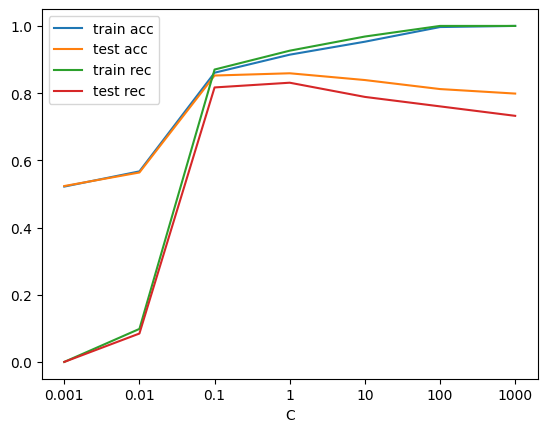

In [78]:
C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]


def rbf_C_plot(C_list, stringify):
    scores_list = []
    scores_list_train = []
    scores_list_recall = []
    scores_list_train_recall = []
    
    for C in C_list:
        model = SVC(kernel='rbf', random_state=42, C=C)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores_list.append(accuracy_score(y_test, y_pred))
        scores_list_recall.append(recall_score(y_test, y_pred))
        
        y_pred = model.predict(X_train)
        
        scores_list_train.append(accuracy_score(y_train, y_pred))
        scores_list_train_recall.append(recall_score(y_train, y_pred))
    
    if stringify:
        C_list = [str(i) for i in C_list]

    plt.plot(C_list, scores_list_train, label='train acc')
    plt.plot(C_list, scores_list, label='test acc')
    plt.plot(C_list, scores_list_train_recall, label='train rec')
    plt.plot(C_list, scores_list_recall, label='test rec')
    plt.legend()
    plt.xlabel('C')

rbf_C_plot(C_list, 1)

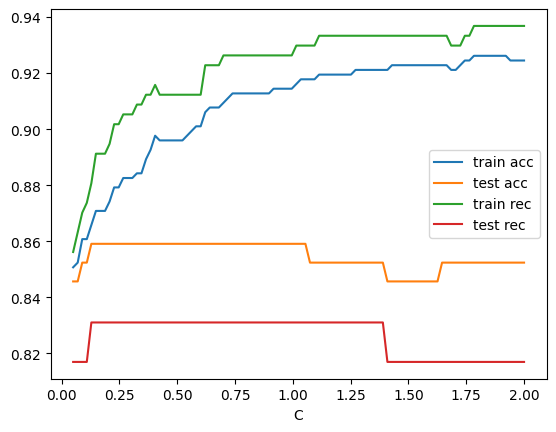

In [79]:
rbf_C_plot(np.linspace(0.05,2,num=100), 0)

Aby uniknąć przetrenowania modelu, użyjemy parametru C = 0.25. Zobaczmy, czy dostosowanie parametru gamma poprawi jakość naszego modelu.

In [80]:
gamma_list = ['scale', 'auto']

for gamma in gamma_list:
    print(f"{gamma} acc = {cross_val_score(SVC(kernel='rbf', random_state=42, C = 0.25, gamma=gamma), X_train, y_train, cv=10).mean():.3f}, 
          czułość = {cross_val_score(SVC(kernel='rbf', random_state=42, C = 0.25, gamma=gamma), X_train, y_train, cv=10, scoring='recall').mean():.3f}")

scale acc = 0.856, czułość = 0.884
auto acc = 0.851, czułość = 0.884


Domyślna wartość scale, której gamma jest równa 1 / (n_features * X.var()) okazała się być lepsza niż auto [1 / n_features]. Zobaczmy, czy manualnym dostosowaniem tego parametru uda się polepszyć wyniki modelu.

In [81]:
gamma_list= [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5]

def rbf_gamma_plot(gamma_list, stringify):
    scores_list = []
    scores_list_train = []
    scores_list_recall = []
    scores_list_train_recall = []

    for gamma in gamma_list:
        model = SVC(kernel='rbf', random_state=42, gamma=gamma, C = 0.25)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        scores_list.append(accuracy_score(y_test, y_pred))
        scores_list_recall.append(recall_score(y_test, y_pred))

        y_pred = model.predict(X_train)

        scores_list_train.append(accuracy_score(y_train, y_pred))
        scores_list_train_recall.append(recall_score(y_train, y_pred))

    if stringify:
        gamma_list = [str(i) for i in gamma_list]

    plt.plot(gamma_list, scores_list_train, label='train acc')
    plt.plot(gamma_list, scores_list, label='test acc')
    plt.plot(gamma_list, scores_list_train_recall, label='train rec')
    plt.plot(gamma_list, scores_list_recall, label='test rec')
    plt.legend()
    plt.xlabel('gamma')
    plt.show()

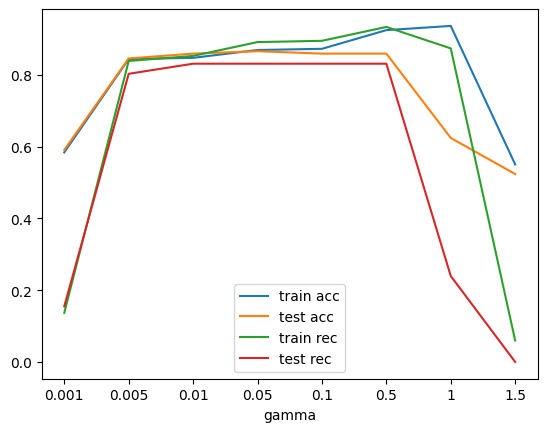

In [82]:
rbf_gamma_plot(gamma_list, 1)

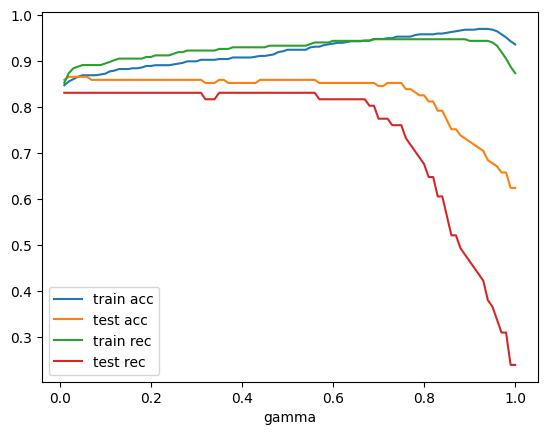

In [83]:
rbf_gamma_plot(np.linspace(0.01,1,num=100), 0)

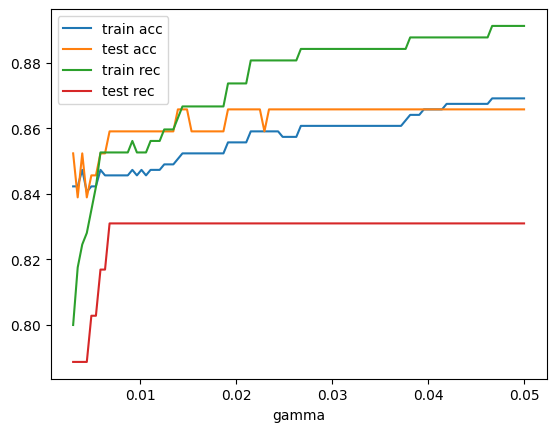

In [84]:
rbf_gamma_plot(np.linspace(0.003,0.05,num=100), 0)

Gamma = 0.04 jest miejscem przecięcia wyniku dokładności modelu na zbiorze treningwym i testowym, taką też wybierzemy.

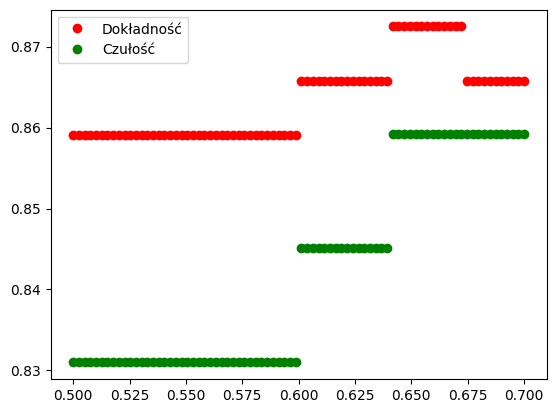

In [85]:
model_acc = []
model_rec = []
gammas = np.linspace(0.5, 0.7, num=80)

for gamma in gammas:
    model = SVC(kernel='rbf', random_state=42, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_acc.append(accuracy_score(y_test, y_pred))
    model_rec.append(recall_score(y_test, y_pred))
    
plt.plot(gammas, model_acc, 'ro', label='Dokładność')
plt.plot(gammas, model_rec, 'go', label='Czułość')
plt.legend()
plt.show()

In [86]:
model = SVC(kernel='rbf', random_state=42, gamma=0.04, C=0.25)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Dokładność:     0.866
Czułość:        0.831
Specyficzność:  0.897
Avg Dokładność CV:     0.877
Avg Czułość CV:        0.849


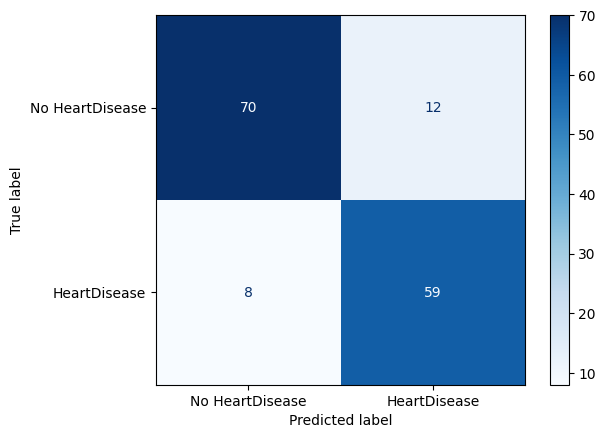

In [87]:
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")
print(f"Avg Dokładność CV:     {cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean():.3f}")
print(f"Avg Czułość CV:        {cross_val_score(model, X_train, y_train, cv=10).mean():.3f}")

Dokładność:     0.866
Czułość:        0.888
Specyficzność:  0.846


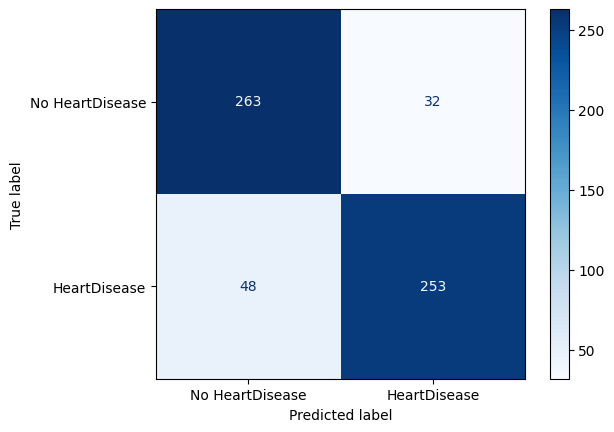

In [88]:
y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_pred, y_train, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_train, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_train, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_train, y_pred, pos_label=0):.3f}")

# 3. KNN

Zobaczmy jak liczba k wpłynie na wyniki acc dla domyślnego modelu na zbiorze testowym i treningowym

In [89]:
def k_przetrenowanie(metric, k_list):
    scores_list = []
    scores_list_train = []
    scores_list_recall = []
    scores_list_train_recall = []
    
    
    for k in k_list:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        scores_list.append(accuracy_score(y_test, y_pred))
        scores_list_recall.append(recall_score(y_test, y_pred))

        y_pred = model.predict(X_train)

        scores_list_train.append(accuracy_score(y_train, y_pred))
        scores_list_train_recall.append(recall_score(y_train, y_pred))
        
    plt.plot(k_list,scores_list_train, label='train acc')
    plt.plot(k_list,scores_list, label='test acc')
    plt.plot(k_list,scores_list_train_recall, label='train rec')
    plt.plot(k_list,scores_list_recall, label='test rec')
    
    plt.legend()
    plt.xlabel('k sąsiadów')
    plt.title(metric)
    plt.show()

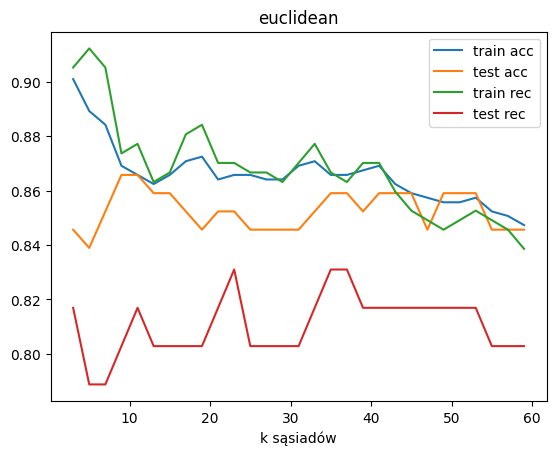

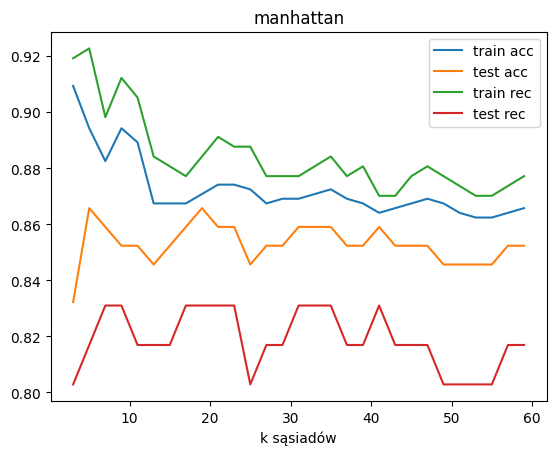

In [90]:
distance_list = ['euclidean', 'manhattan']
k_list = range(3,61, 2)
for metric in distance_list:
    k_przetrenowanie(metric, k_list)

Dla odległości mahattan i k = 19 w modelu KNN maksymalizujemy dokładkość przy zachwaniu najwyższej możliwej czułości i unikamy przetrenowania.

In [93]:
def k_plot(metric):
    k_list = range(1,61, 2)
    scores_list = []
    scores_list_CV = []
    scores_list_rec = []
    scores_list_CV_rec = []

    
    for k in k_list:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores_list.append(accuracy_score(y_test, y_pred))
        scores_list_CV.append(cross_val_score(model, X_train, y_train, cv=10).mean())
        scores_list_rec.append(recall_score(y_test, y_pred))
        scores_list_CV_rec.append(cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean())
    
    plt.plot(k_list, scores_list, label='model acc')
    plt.plot(k_list, scores_list_CV, label='CV acc avg')
    plt.plot(k_list, scores_list_rec, label='model rec')
    plt.plot(k_list, scores_list_CV_rec, label='CV avg rec')

    plt.legend()
    plt.title(metric)
    plt.xlabel('k sąsiadów')
    # plt.ylim(0.79,0.88)
    plt.show()

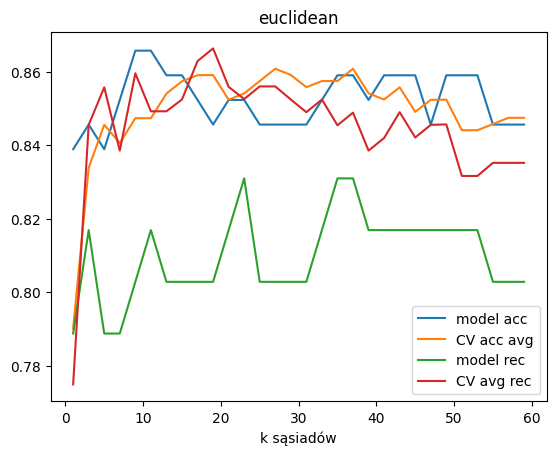

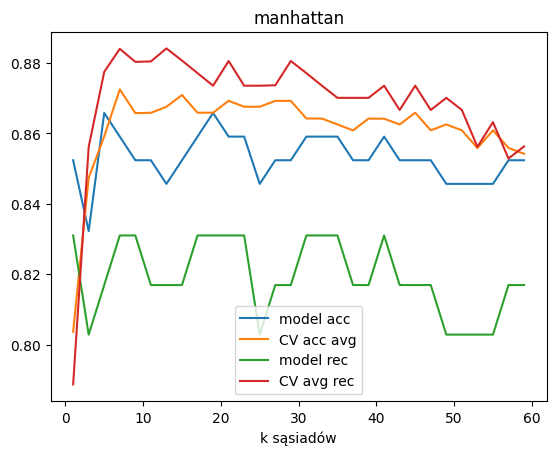

In [94]:
for metric in distance_list:
    k_plot(metric)

Używając odległości manhattan osiągamy lepsze przeciętne wyniki dla średniej z 10 splitów CV, niż gdy używamy metryki euklidesowej. Osiągamy też wyższą maksymalną dokładność na badanym zbiorze train test. 

Dokładność:     0.866
Czułość:        0.831
Specyficzność:  0.897
Avg Dokładność CV:     0.874
Avg Czułość CV:        0.866


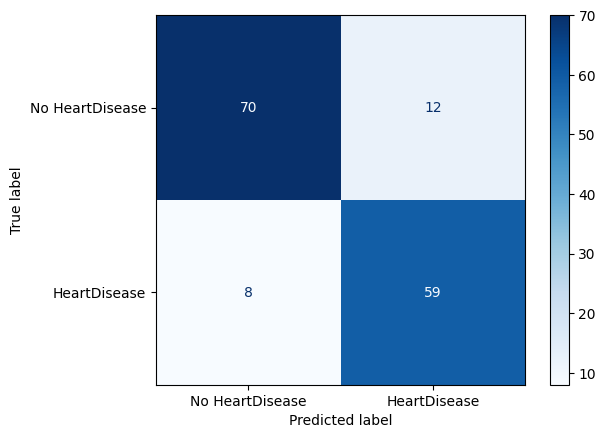

In [97]:
model = KNeighborsClassifier(n_neighbors=19, metric='manhattan')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_pred, y_test, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_test, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_test, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_test, y_pred, pos_label=0):.3f}")
print(f"Avg Dokładność CV:     {cross_val_score(model, X_train, y_train, cv=10, scoring='recall').mean():.3f}")
print(f"Avg Czułość CV:        {cross_val_score(model, X_train, y_train, cv=10).mean():.3f}")

Dokładność:     0.871
Czułość:        0.884
Specyficzność:  0.859


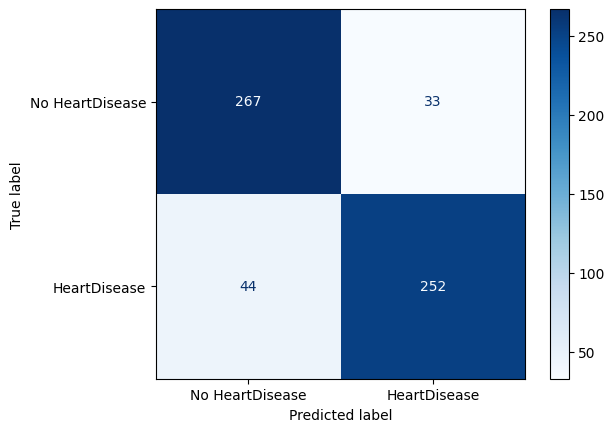

In [98]:
y_pred = model.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_pred, y_train, display_labels=['No HeartDisease', 'HeartDisease'], cmap='Blues')
plt.grid(False)

print(f"Dokładność:     {accuracy_score(y_train, y_pred):.3f}")
print(f"Czułość:        {recall_score(y_train, y_pred):.3f}")
print(f"Specyficzność:  {recall_score(y_train, y_pred, pos_label=0):.3f}")